# Create an RAG Pipeline with Conditional Routes

Here, a branching RAG pipeline will be implemented that incorporates a fallback mechanism to perform a web search when the the pipeline cannot answer a user's query from the stored documents.

### Preliminaries


Since we will use the `OpenAIGenerator` and `SerperDevWebSearch` components, we need to make the correspondig API keys accessible via environment.

You need to sign up on [Serper](serper.dev), a Google Search API, where you have 2.500 queries for free. Store your api key as `SERPERDEV_API_KEY` in the `.env` file.

In [14]:
from dotenv import load_dotenv
load_dotenv()

True

### Set up Documents and Document Store

In [2]:
from haystack import Document

documents = [Document(content="Retrievers: Retrieves relevant documents to a user query using keyword search or semantic search."),
             Document(content="Embedders: Creates embeddings for text or documents."),
             Document(content="Generators: Use a number of model providers to generate answers or content based on a prompt"),
             Document(content="File Converters: Converts different file types like TXT, Markdown, PDF, etc. into a Haystack Document type")]

In [3]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=documents)

4

### Create RAG Pipeline

In [4]:
from haystack import Pipeline
from haystack.components.retrievers import InMemoryBM25Retriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

rag = Pipeline()
rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag.add_component("llm", OpenAIGenerator())

rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

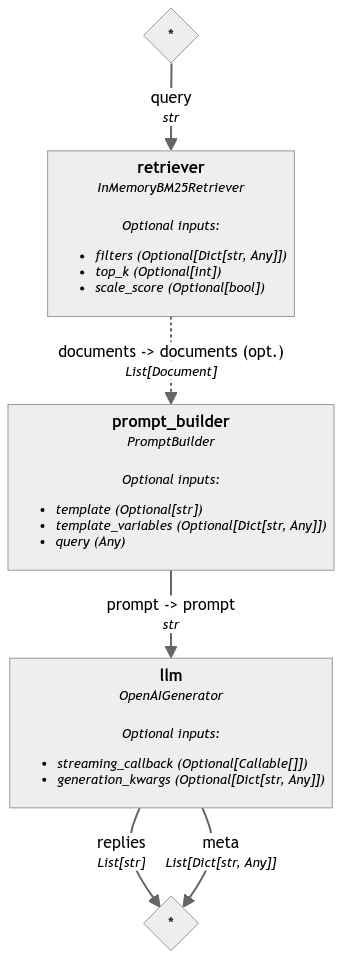

In [5]:
rag.show()

In [6]:
query = "What is a retriever for?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ['Retrievers are used to retrieve relevant documents to a user query using keyword search or semantic search.'],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 20,
     'prompt_tokens': 117,
     'total_tokens': 137}}]}}

In [7]:
query = "What Mistral components are there?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ['no_answer'],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 43,
     'total_tokens': 45}}]}}

### Create Conditional Routes

To use the `ConditionalRouter` component, define custom _routes_ with conditions. This component will trigger a specific branch of the pipeline when a condition is met.

In this example, we'll use the `ConditionalRouter` to determine if the RAG pipeline can provide an answer, and if not, it will fall back to a web search when the stored documents lack the necessary information regarding the query.


In [9]:
from haystack.components.routers import ConditionalRouter

routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

router = ConditionalRouter(routes=routes)

In [10]:
router.run(replies=['Geoff is my friend'], query="Who is Geoff?")

{'answer': 'Geoff is my friend'}

In [11]:
router.run(replies=['No_answer'], query="Who is Geoff?")

{'go_to_websearch': 'Who is Geoff?'}

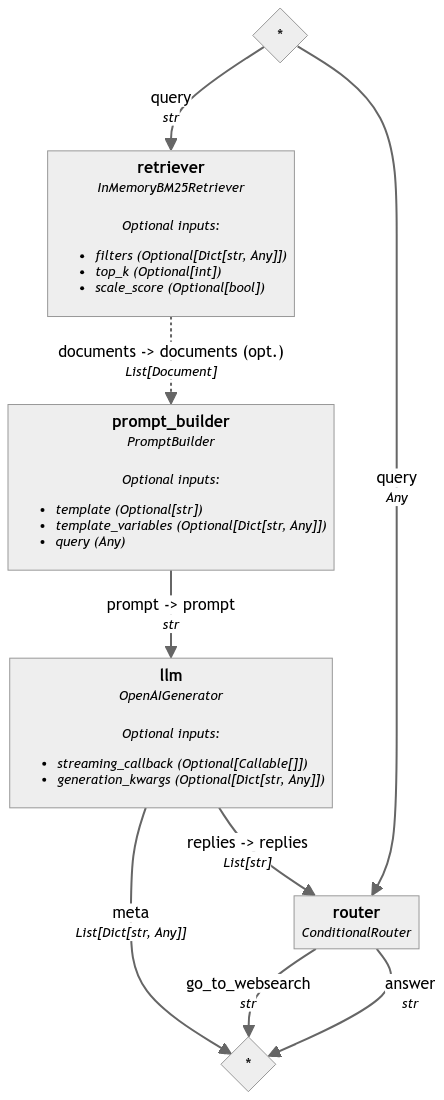

In [12]:
rag.add_component("router", ConditionalRouter(routes=routes))
rag.connect("llm.replies", "router.replies")

rag.show()

In [13]:
query = "What Mistral components does Haystack have?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query},
         "router": {"query": query}})

{'llm': {'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 119,
     'total_tokens': 121}}]},
 'router': {'go_to_websearch': 'What Mistral components does Haystack have?'}}

### Create Websearch Branch

In [15]:
from haystack.components.websearch import SerperDevWebSearch

prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

rag.add_component("websearch", SerperDevWebSearch())
rag.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag.add_component("llm_for_websearch", OpenAIGenerator())

rag.connect("router.go_to_websearch", "websearch.query")
rag.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag.connect("prompt_builder_for_websearch", "llm_for_websearch")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - router: ConditionalRouter
  - websearch: SerperDevWebSearch
  - prompt_builder_for_websearch: PromptBuilder
  - llm_for_websearch: OpenAIGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])
  - router.go_to_websearch -> websearch.query (str)
  - router.go_to_websearch -> prompt_builder_for_websearch.query (str)
  - websearch.documents -> prompt_builder_for_websearch.documents (List[Document])
  - prompt_builder_for_websearch.prompt -> llm_for_websearch.prompt (str)

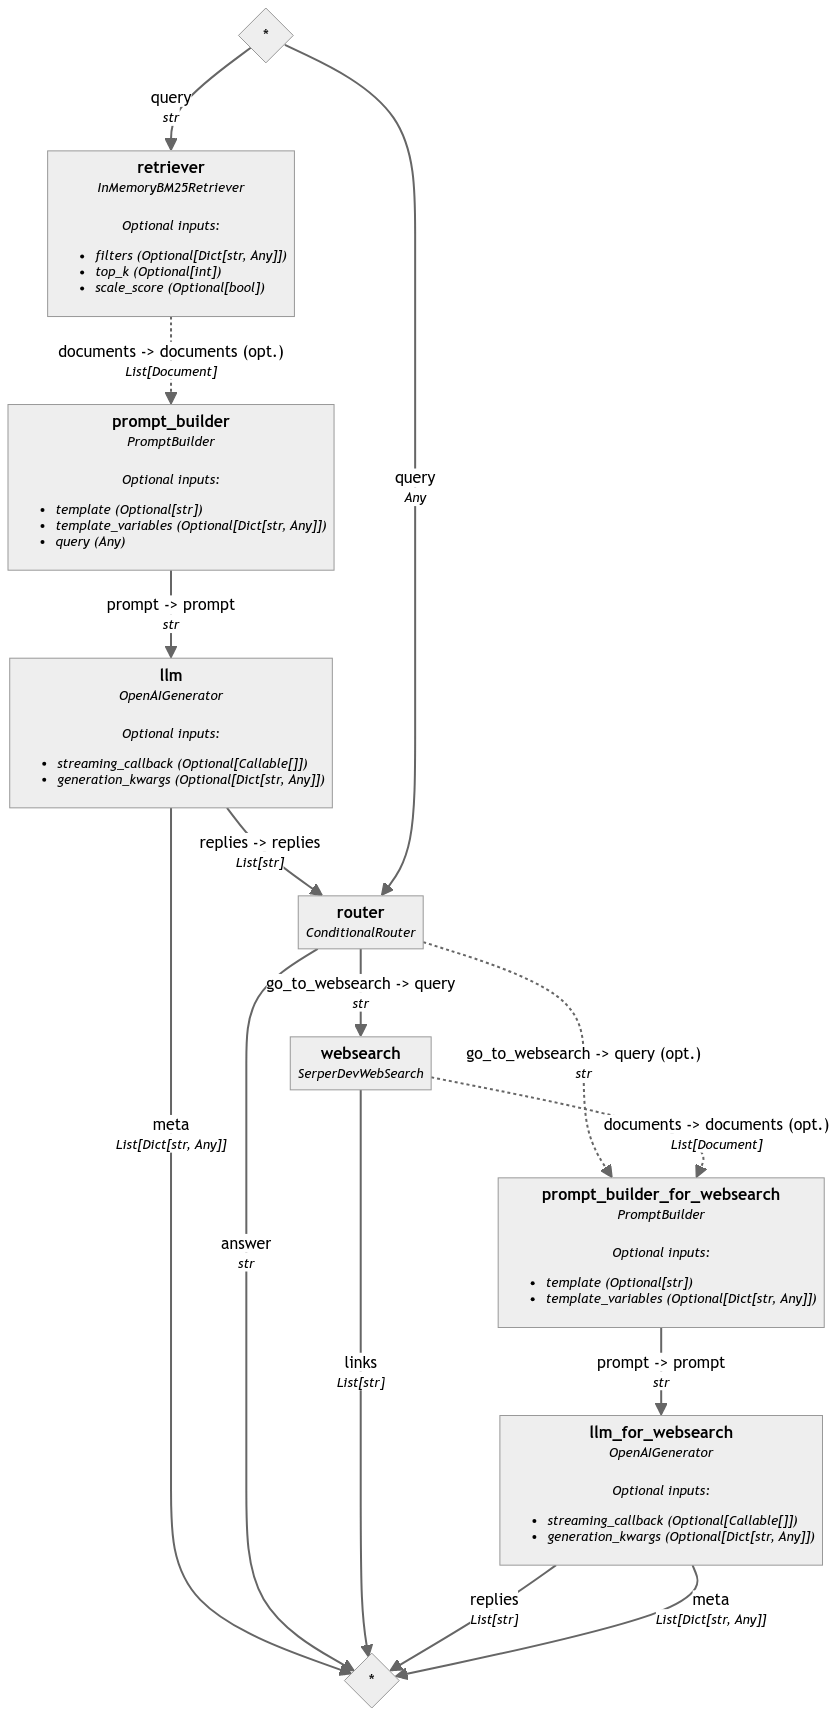

In [16]:
rag.show()

In [18]:
query= "What is a retriever for?"

rag.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})['router']['answer']

'Retrievers are for retrieving relevant documents to a user query using keyword search or semantic search.'

In [20]:
query = "What Mistral components does Haystack have?"

rag.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}}) 

{'llm': {'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 119,
     'total_tokens': 121}}]},
 'websearch': {'links': ['https://docs.haystack.deepset.ai/reference/integrations-mistral',
   'https://github.com/deepset-ai/haystack-integrations/blob/main/integrations/mistral.md',
   'https://github.com/anakin87/mistral-haystack/blob/main/mistral_haystack.ipynb',
   'https://docs.mistral.ai/guides/rag/',
   'https://www.e2enetworks.com/blog/rag-implementation-using-mistral-7b-haystack-and-weaviate',
   'https://www.toolify.ai/ai-news/build-an-efficient-rag-model-with-haystack-and-mistral-7b-1476907',
   'https://khadkechetan.medium.com/information-extraction-with-mistral-8x7b-47111b8bd035',
   'https://www.restack.io/p/haystack-utilities-answer-cat-ai',
   'https://www.youtube.com/watch?v=8qqaqefugWQ']},
 'llm_for_websearch': {'replies': ['Based on the documents retrieved, Mistral components tha